### **TD 11-12**
JACQUIN Valentin et PREHAUD Benjamin

In [48]:
import pandas as pd
import numpy as np
import re as re
from deep_translator import GoogleTranslator
import textblob as tb

### **Récolte de tweet via la librairie *Tweepy***

In [49]:
import tweepy as tw

In [50]:
# S'il vous plaît, évitez de prendre cette clé... 
bearer_token = "AAAAAAAAAAAAAAAAAAAAALlvjwEAAAAA25TEUnT2N8eEELc9gfzSEg3leKU%3Dhn4wDQCAuim5DVV58EDOYRPaYfwIgRwjiUpGYSfp5lpXaFd58N"

In [51]:
# Initialisation du client avec les clé d'autorisation de l'appli créée sur le portail
# développeur de l'API twitter.
client = tw.Client(bearer_token=bearer_token)
# On recherche les derniers tweet ayant versailles dans leur texte,
# on spécifie les informations qu'on veut récuperer, annotations, created_at...
reponse = client.search_recent_tweets(query="Versailles", expansions="author_id", tweet_fields=[
    "context_annotations",
    "created_at",
    "public_metrics",
    "author_id",
    "geo",
    "entities",
    "attachments",
    "lang"
    ],
    max_results=100)
dfScrappingVersailles = pd.DataFrame(reponse.data)


In [52]:
dfScrappingVersailles

,attachments,author_id,context_annotations,created_at,edit_history_tweet_ids,entities,geo,id,lang,public_metrics,text
0,NaN,1573682783704256513,NaN,2022-12-13 18:04:57+00:00,[1602726283267350529],NaN,NaN,1602726283267350529,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","And I’m sorry I left, but it was for the best\..."
1,NaN,577109423,NaN,2022-12-13 18:02:39+00:00,[1602725703002345476],"{'hashtags': [{'start': 114, 'end': 126, 'tag'...",NaN,1602725703002345476,fr,"{'retweet_count': 8, 'reply_count': 0, 'like_c...",RT @VaduAmka: Parce qu’on a besoin d’un peu d’...
2,NaN,2423647883,NaN,2022-12-13 18:02:34+00:00,[1602725682311794689],"{'mentions': [{'start': 3, 'end': 17, 'usernam...",NaN,1602725682311794689,fr,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",RT @royalsodapapi: Jeudi je reprends mon titre...
3,NaN,1511241117747929089,NaN,2022-12-13 18:01:11+00:00,[1602725334834909185],"{'mentions': [{'start': 3, 'end': 16, 'usernam...",NaN,1602725334834909185,en,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",RT @starseed_777: Versailles is located on a v...
4,NaN,1098904639196594176,NaN,2022-12-13 18:01:03+00:00,[1602725302534344705],NaN,NaN,1602725302534344705,fr,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",15. Versailles genre ? jsp j'ai toujours voulu...
...,...,...,...,...,...,...,...,...,...,...,...
95,"{'media_keys': ['3_1602711196876132352', '3_16...",1569967652,NaN,2022-12-13 17:05:02+00:00,[1602711202433585157],"{'urls': [{'start': 19, 'end': 42, 'url': 'htt...",NaN,1602711202433585157,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Versailles is wild https://t.co/7vQba8Kb0T
96,NaN,4321100963,NaN,2022-12-13 17:02:58+00:00,[1602710682042093570],"{'mentions': [{'start': 0, 'end': 14, 'usernam...",NaN,1602710682042093570,fr,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","@RemiTrainPCLM @VanhGuss Ça y est, à 5mn du dé..."
97,NaN,1580960119688495110,NaN,2022-12-13 17:02:26+00:00,[1602710550546448386],"{'hashtags': [{'start': 106, 'end': 113, 'tag'...",NaN,1602710550546448386,fr,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",RT @watatsumiLP: [presse] Au collège Petit Ver...
98,NaN,2872930061,NaN,2022-12-13 17:01:32+00:00,[1602710322712023040],"{'mentions': [{'start': 3, 'end': 16, 'usernam...",NaN,1602710322712023040,fr,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",RT @AnneBergantz: Ravie d’avoir pu accueillir ...


> Pour faire ce code, je me suis inspiré de plusieurs sites mais principalement de [celui-ci](https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9)

# Lecture de données JSON
Grâce à la librairie ***panda***, on peut facilement lire les fichiers JSON. Ils seront converti en dataframe.

In [53]:
pdTweet = pd.read_json(path_or_buf="versailles_tweets_100.json")
# On peut concaténer les deux dataframe avec cette fonction
pdTweet = pd.concat([pdTweet, dfScrappingVersailles], axis=0, ignore_index=True)
pdTweet

,_id,public_metrics,id,conversation_id,author_id,text,geo,lang,created_at,entities,context_annotations,attachments,edit_history_tweet_ids
0,1.421616e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1421616335700824064,1.421616e+18,1339914264522461184,Goumin des éléphants joueurs la même fatigue m...,{'place_id': '00b8943291443c8c'},fr,2021-07-31 23:38:41+00:00,"{'hashtags': [{'start': 52, 'end': 63, 'tag': ...",NaN,NaN,NaN
1,1.421600e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1421599703116943360,1.421600e+18,1339914264522461184,@ericbailly24 @maxigr04del mes tontons vous a...,{'place_id': '00b8943291443c8c'},fr,2021-07-31 22:32:35+00:00,"{'mentions': [{'start': 0, 'end': 13, 'usernam...","[{'domain': {'id': '6', 'name': 'Sports Event'...",NaN,NaN
2,1.421599e+18,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1421599163561742336,1.421599e+18,1339914264522461184,Ah oui le sommeil là sera compliqué. #CIV est...,{'place_id': '00b8943291443c8c'},fr,2021-07-31 22:30:27+00:00,"{'hashtags': [{'start': 37, 'end': 41, 'tag': ...","[{'domain': {'id': '6', 'name': 'Sports Event'...",NaN,NaN
3,1.421592e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1421591889095057408,1.421592e+18,1339914264522461184,"31 juillet , journée internationale de la femm...",{'place_id': '00b8943291443c8c'},fr,2021-07-31 22:01:32+00:00,"{'hashtags': [{'start': 60, 'end': 65, 'tag': ...",NaN,NaN,NaN
4,1.421583e+18,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1421582795294617600,1.421583e+18,717025418,Le pedigree 😂😂😂😂 https://t.co/D3Rv7A2BOF,{'place_id': '00b8943291443c8c'},es,2021-07-31 21:25:24+00:00,"{'urls': [{'start': 17, 'end': 40, 'url': 'htt...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1602711202433585157,NaN,1569967652,Versailles is wild https://t.co/7vQba8Kb0T,NaN,en,2022-12-13 17:05:02+00:00,"{'urls': [{'start': 19, 'end': 42, 'url': 'htt...",NaN,"{'media_keys': ['3_1602711196876132352', '3_16...",[1602711202433585157]
116,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1602710682042093570,NaN,4321100963,"@RemiTrainPCLM @VanhGuss Ça y est, à 5mn du dé...",NaN,fr,2022-12-13 17:02:58+00:00,"{'mentions': [{'start': 0, 'end': 14, 'usernam...",NaN,NaN,[1602710682042093570]
117,NaN,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",1602710550546448386,NaN,1580960119688495110,RT @watatsumiLP: [presse] Au collège Petit Ver...,NaN,fr,2022-12-13 17:02:26+00:00,"{'hashtags': [{'start': 106, 'end': 113, 'tag'...",NaN,NaN,[1602710550546448386]
118,NaN,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",1602710322712023040,NaN,2872930061,RT @AnneBergantz: Ravie d’avoir pu accueillir ...,NaN,fr,2022-12-13 17:01:32+00:00,"{'mentions': [{'start': 3, 'end': 16, 'usernam...",NaN,NaN,[1602710322712023040]


# Partie nettoyage du texte
Gestion des retours à la ligne:

In [54]:

def no_retourchariot(texte:str):
    """
    Fonction qui retire les retours à la ligne du texte.
    """
    patern = re.compile("\n")
    result = patern.sub(r"",texte)
    return result

Extraction des tweet sans emoticônes (Expressions régulières):


[Source du code unicode](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b?permalink_comment_id=3315605#gistcomment-3315605)

In [55]:

def no_emoticone(texte:str):
        """
        Fonction qui retire tout les émoticones du texte donné.
        """
        patern  = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                                "]+", flags = re.UNICODE)
        
        result = patern.sub(r"",texte)
        return result

Retire mention du texte d'un tweet

In [56]:
def no_mention(texte:str):
    """
    Fonction qui retire les mentions du texte donné
    """
    patern = re.compile("@\S*")
    result = patern.sub(r"",texte)
    return result

Retire les hastags d'un tweet

In [57]:
def no_hastags(chiffre):
    """fonction qui retire les hastags du tweet"""
    patern = re.compile("#\S*")
    result = patern.sub(r"",chiffre)
    return result

Retire l'intégration d'un URL dans un tweet

In [58]:

def no_URL(texte):
    """
    Fonction qui retire l'URL d'un tweet
    """
    patern = re.compile("https://\S*")
    result = patern.sub(r"", texte)
    return result


Fonction qui nettoie le texte avec toutes les fonctions créé auparavant.

In [59]:
def menage(numeroTweet:int, source:pd.DataFrame):
    """
    Fonction qui applique les fonctions créé auparavant pour avoir un texte vierge
    """
    texte = source["text"][numeroTweet]
    texte = no_retourchariot(texte)
    texte = no_emoticone(texte)
    texte = no_mention(texte)
    texte = no_hastags(texte)
    texte = no_URL(texte)
    return texte

In [60]:
pdTweetFiltre = pd.DataFrame()
pdTweetFiltre

""


Maintenant, il faut insérer les tweets avec les texte nettoyé dans le nouveau DataFrame

In [61]:
#insertion du texte nettoyé dans le Data Frame TweetFiltrer
list_texte = []
for i in range(0,len(pdTweet["text"])):
    texte = menage(i, pdTweet)
    list_texte.append(texte)
pdTweetFiltre["Texte"] = pd.Series(list_texte)
pdTweetFiltre

,Texte
0,Goumin des éléphants joueurs la même fatigue m...
1,"mes tontons vous avez fait votre part , JO ..."
2,Ah oui le sommeil là sera compliqué. est éli...
3,"31 juillet , journée internationale de la femm..."
4,Le pedigree
...,...
115,Versailles is wild
116,"Ça y est, à 5mn du départ, plus de places de..."
117,RT [presse] Au collège Petit Versailles de la...
118,RT Ravie d’avoir pu accueillir les élèves du ...


<H3>Partie gestion Mentions URl et Hashtags<H3/>

In [62]:
# Crée un dataFrame avec les données inscrites dans entites, en columns on a: Url, Mentions et Hashtags
pdEntities = pdTweet["entities"].apply(pd.Series)
# On supprime la column 0 qui ne contient rien.
del pdEntities[0]
pdEntities

,hashtags,mentions,urls,annotations
0,"[{'start': 52, 'end': 63, 'tag': 'twitter225'}]",NaN,NaN,NaN
1,"[{'start': 126, 'end': 142, 'tag': 'Supportric...","[{'start': 0, 'end': 13, 'username': 'ericbail...",NaN,NaN
2,"[{'start': 37, 'end': 41, 'tag': 'CIV'}]",NaN,NaN,NaN
3,"[{'start': 60, 'end': 65, 'tag': 'jifa'}]",NaN,NaN,NaN
4,NaN,NaN,"[{'start': 17, 'end': 40, 'url': 'https://t.co...",NaN
...,...,...,...,...
115,NaN,NaN,"[{'start': 19, 'end': 42, 'url': 'https://t.co...","[{'start': 0, 'end': 9, 'probability': 0.6707,..."
116,NaN,"[{'start': 0, 'end': 14, 'username': 'RemiTrai...",NaN,NaN
117,"[{'start': 106, 'end': 113, 'tag': 'sarthe'}]","[{'start': 3, 'end': 15, 'username': 'watatsum...",NaN,NaN
118,NaN,"[{'start': 3, 'end': 16, 'username': 'AnneBerg...",NaN,NaN


Cette cellule trie les informations stockées dans la colonnes "Entities" dans le dataframe initial et le stocke dans un autre dataframe.

In [63]:
for columns_name in pdEntities:
        # longueur de la colonne
        lenSeries = len(pdEntities[columns_name])
        lElement = []
        # Les données sont parfois stocké sous forme de dictionnaire,
        # pour chaque nom on définit la clé du dictionnaire qui nous intérèsse.
        if columns_name == "hashtags":
                key = "tag"
        elif columns_name == "mentions":
                key = "username"
        elif columns_name == "urls":
                key = "url"
        else:
                key = None
        for tweet in range(0,lenSeries):
                # Pour chaque élement, il peut y avoir plusieurs entités, par 
                # exemple dans le cas des hashtags, il peut y avoir plusieurs hashtag par tweet.
                # on va donc les stocker dans une sous liste.
                lElementUnder = []
                if type(pdEntities[columns_name][tweet]) == list:
                        for j in range(0, int(len(pdEntities[columns_name][tweet]))):
                                lElementUnder.append(pdEntities[columns_name][tweet][j].get(key))
                # Si l'élement n'est pas une liste, il est forcément vide dans notre base de donnée.
                # on crée donc une sous liste vide.
                else:
                        lElementUnder.append(None)
                lElement.append(lElementUnder)
        lElement = pd.Series(lElement)
        pdTweetFiltre[columns_name] = lElement
pdTweetFiltre

,Texte,hashtags,mentions,urls,annotations
0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None]
1,"mes tontons vous avez fait votre part , JO ...","[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",[None],[None]
2,Ah oui le sommeil là sera compliqué. est éli...,[CIV],[None],[None],[None]
3,"31 juillet , journée internationale de la femm...",[jifa],[None],[None],[None]
4,Le pedigree,[None],[None],[https://t.co/D3Rv7A2BOF],[None]
...,...,...,...,...,...
115,Versailles is wild,[None],[None],"[https://t.co/7vQba8Kb0T, https://t.co/7vQba8K...",[None]
116,"Ça y est, à 5mn du départ, plus de places de...",[None],"[RemiTrainPCLM, VanhGuss]",[None],[None]
117,RT [presse] Au collège Petit Versailles de la...,[sarthe],[watatsumiLP],[None],[None]
118,RT Ravie d’avoir pu accueillir les élèves du ...,[None],"[AnneBergantz, ise_ecole]",[None],[None]


On rajoute les id des auteurs dans le dataframe

In [64]:
pdTweetFiltre["author"] = pdTweet["author_id"]
pdTweetFiltre

,Texte,hashtags,mentions,urls,annotations,author
0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None],1339914264522461184
1,"mes tontons vous avez fait votre part , JO ...","[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",[None],[None],1339914264522461184
2,Ah oui le sommeil là sera compliqué. est éli...,[CIV],[None],[None],[None],1339914264522461184
3,"31 juillet , journée internationale de la femm...",[jifa],[None],[None],[None],1339914264522461184
4,Le pedigree,[None],[None],[https://t.co/D3Rv7A2BOF],[None],717025418
...,...,...,...,...,...,...
115,Versailles is wild,[None],[None],"[https://t.co/7vQba8Kb0T, https://t.co/7vQba8K...",[None],1569967652
116,"Ça y est, à 5mn du départ, plus de places de...",[None],"[RemiTrainPCLM, VanhGuss]",[None],[None],4321100963
117,RT [presse] Au collège Petit Versailles de la...,[sarthe],[watatsumiLP],[None],[None],1580960119688495110
118,RT Ravie d’avoir pu accueillir les élèves du ...,[None],"[AnneBergantz, ise_ecole]",[None],[None],2872930061


On fait les mêmes manipulations pour les topics.

In [65]:
sTopics = []
for tweet in pdTweet["context_annotations"]:
    sTopicsTweet = []
    if type(tweet) == list:
        lenSeries = len(tweet)
        for i in range(0, lenSeries):
            topics = tweet[i].get("domain").get("name")
            # On vérifie que le topic ne soit pas déjà inscrit (pas en double)
            if topics not in sTopicsTweet:
                sTopicsTweet.append(topics)
    # Si ce n'est pas une liste, alors il est vide
    else:
        sTopicsTweet.append(None)
    # On stocke la sous-liste dans la liste initiale.
    sTopics.append(sTopicsTweet)
# On insère dans notre DataFrame
pdTweetFiltre["topics"] = sTopics
pdTweetFiltre

,Texte,hashtags,mentions,urls,annotations,author,topics
0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None],1339914264522461184,[None]
1,"mes tontons vous avez fait votre part , JO ...","[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",[None],[None],1339914264522461184,"[Sports Event, Person, Athlete]"
2,Ah oui le sommeil là sera compliqué. est éli...,[CIV],[None],[None],[None],1339914264522461184,[Sports Event]
3,"31 juillet , journée internationale de la femm...",[jifa],[None],[None],[None],1339914264522461184,[None]
4,Le pedigree,[None],[None],[https://t.co/D3Rv7A2BOF],[None],717025418,[None]
...,...,...,...,...,...,...,...
115,Versailles is wild,[None],[None],"[https://t.co/7vQba8Kb0T, https://t.co/7vQba8K...",[None],1569967652,[None]
116,"Ça y est, à 5mn du départ, plus de places de...",[None],"[RemiTrainPCLM, VanhGuss]",[None],[None],4321100963,[None]
117,RT [presse] Au collège Petit Versailles de la...,[sarthe],[watatsumiLP],[None],[None],1580960119688495110,[None]
118,RT Ravie d’avoir pu accueillir les élèves du ...,[None],"[AnneBergantz, ise_ecole]",[None],[None],2872930061,[None]


Utilisation de la libraire ***textBlob*** pour donner le sentiment (négatif ou positif) du tweet à partir de son texte.

On utilise l'api de *Googletranslate* via la libraire *deep-translate* pour traduire le texte auparavant.

In [66]:
def analysis_sentiment(source:pd.DataFrame):
    # Initialisation du traducteur
    translator = GoogleTranslator(target="en")
    liste_sentiment = []
    for i in range(0, len(source["Texte"])):
        # On sort le texte de notre DataFrame
        texte = source["Texte"][i]
        # On le traduit via notre librairie
        texte_Angl = translator.translate(texte)
        # On utilise la librairie textBlob pour analyser le sentiment,
        # dans notre cas on a choisis de prendre que la première donnée de l'analyse
        # la polarité, plus elle est proche de -1 plus le texte est négatif
        # et inversement lorsqu'elle est proche de 1
        liste_sentiment.append(tb.TextBlob(texte_Angl).sentiment[0])
    return liste_sentiment

pdTweetFiltre["sentiment"] = analysis_sentiment(pdTweetFiltre)

On a extrait toutes les informations nécessaires du tweet, on peut maintenant le stocker dans le fichier *"Zone d'atterissage"* qu'on va enregistrer sous le format **CSV**.

In [67]:
pdTweetFiltre.head(1)

,Texte,hashtags,mentions,urls,annotations,author,topics,sentiment
0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None],1339914264522461184,[None],0.0


In [68]:
pdTweetFiltre.to_csv(path_or_buf="zone_atterissage.csv")

Pour lire les tweet dans zone d'atterissage, il suffit de le retransformer en DataFrame le fichier **CSV**, il est plus simple de faire les opérations de lecture de données sur le DataFrame.

> En utilisant le format de fichier CVS, les informations de types ne sont pas enregistrés, on va donc les spécifier.

In [69]:
pdTweetFiltre = pd.read_csv("zone_atterissage.csv", dtype={
    "Texte": str,
    "hashtags": str,
    "mentions": str,
    "urls": str,
    "annotations": str,
    "author": float,
    "topics": str,
    "sentiment": float
})

Le problème est que on ne peut pas mettre **list** dans le typage de *read_csv*.

On va donc utiliser la fonction *ast.literal_eval* pour retransformer les données sous forme de liste. La solution a été trouvé sur ce [site](https://stackoverflow.com/questions/20799593/reading-csv-containing-a-list-in-pandas).

In [70]:
import ast

listeColonneList = ["hashtags", "mentions", "urls", "annotations", "topics"]
for elem in listeColonneList:
    pdTweetFiltre[elem] = pdTweetFiltre[elem].apply(lambda x: ast.literal_eval(x))
pdTweetFiltre

,Unnamed: 0,Texte,hashtags,mentions,urls,annotations,author,topics,sentiment
0,0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None],1.339914e+18,[None],0.000000
1,1,"mes tontons vous avez fait votre part , JO ...","[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",[None],[None],1.339914e+18,"[Sports Event, Person, Athlete]",-0.150000
2,2,Ah oui le sommeil là sera compliqué. est éli...,[CIV],[None],[None],[None],1.339914e+18,[Sports Event],-0.500000
3,3,"31 juillet , journée internationale de la femm...",[jifa],[None],[None],[None],1.339914e+18,[None],0.000000
4,4,Le pedigree,[None],[None],[https://t.co/D3Rv7A2BOF],[None],7.170254e+08,[None],0.000000
...,...,...,...,...,...,...,...,...,...
115,115,Versailles is wild,[None],[None],"[https://t.co/7vQba8Kb0T, https://t.co/7vQba8K...",[None],1.569968e+09,[None],0.100000
116,116,"Ça y est, à 5mn du départ, plus de places de...",[None],"[RemiTrainPCLM, VanhGuss]",[None],[None],4.321101e+09,[None],-0.025000
117,117,RT [presse] Au collège Petit Versailles de la...,[sarthe],[watatsumiLP],[None],[None],1.580960e+18,[None],0.000000
118,118,RT Ravie d’avoir pu accueillir les élèves du ...,[None],"[AnneBergantz, ise_ecole]",[None],[None],2.872930e+09,[None],0.666667


Affichage des tweets d'un utilisateur :

In [71]:
def tweet_author(author_id:int):
    """
    Fonction qui affiche tout les tweets d'un utilisateur donné
    """
    serie = pd.Series([author_id for i in range(len(pdTweetFiltre["author"]))])
    return pdTweetFiltre[pdTweetFiltre["author"].isin(serie)]

tweet_author(1339914264522461184)

,Unnamed: 0,Texte,hashtags,mentions,urls,annotations,author,topics,sentiment
0,0,Goumin des éléphants joueurs la même fatigue m...,[twitter225],[None],[None],[None],1.339914e+18,[None],0.00
1,1,"mes tontons vous avez fait votre part , JO ...","[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",[None],[None],1.339914e+18,"[Sports Event, Person, Athlete]",-0.15
2,2,Ah oui le sommeil là sera compliqué. est éli...,[CIV],[None],[None],[None],1.339914e+18,[Sports Event],-0.50
3,3,"31 juillet , journée internationale de la femm...",[jifa],[None],[None],[None],1.339914e+18,[None],0.00


Affichage de l'ensemble des tweets mentionnant un utilisateur spécifique :

In [72]:
def tweet_mention(mention):
    """
    Fonction qui affiche le texte de/ou des tweets nettoyés ayant la mention de la personne dedans
    """
    for i in range(0, len(pdTweetFiltre["mentions"])):
        liste_mention = pdTweetFiltre["mentions"][i]
        for j in range(0, len(liste_mention)):
            liste_mention
            mention_tab = liste_mention[j]
            if mention == mention_tab :
                print(pdTweetFiltre["Texte"][i])

tweet_mention("ericbailly24")

   mes tontons vous avez fait votre part , JO prochain on ira en demi final au moins. BRAVO à vous .   


Affichage des Utilisateurs utilisant un Hashtag spécifique :

In [73]:
def tweet_hashtags(hashtag):
    """fonction qui va afficher le ou les utilisateurs ayants utilisés le hastags dans leur tweet"""
    for i in range(0, len(pdTweetFiltre["hashtags"])):
        liste_hashtags = pdTweetFiltre["hashtags"][i]
        for j in range(0, len(liste_hashtags)):
            mention_tab = liste_hashtags[j]
            if hashtag == mention_tab :
                print(pdTweetFiltre["author"][i])

tweet_hashtags("versailles")

1471684208.0


Affichage des utilisateurs mentionnés dans les tweets d'un autre utilisateur :

In [74]:
def author_mention(author):
    """
    fonction qui affiche les mentions qu'un utilisateur a fait dans ses tweets
    """
    liste_mention = 0
    mention = []
    for i in range(0, len(tweet_author(author))):
        liste_mention = list(tweet_author(author)["mentions"][i])
        if liste_mention != [None] and liste_mention != ["None"]:
            for j in range(0,len(liste_mention)):
                mention.append(liste_mention[j])
    return set(mention)

    
author_mention(1339914264522461184)

{'ericbailly24', 'maxigr04del'}

# Top K

On va lire dans le DataFrame qu'on a créé les différents hashtags présent.

Pour chaque hashtag, s'il est dans la liste des clés déja renseigné, on ajoute + 1 a la valeur de la clé. Sinon, on le rajoute dans la liste des clés et on l'initialise à 1.

On va ensuite obtenir les valeurs les plus grandes du dictionnaire avec la fonction max. Si la valeur est représenté plusieurs fois (2ième exaquo) on montrera toutes les valeurs qui correpondent au maximum.

Les données sont organisées de la même manière pour les mentions et les url. On peut donc créer une fonction qui prend 3 arguments:
- **k** qui correspond le nombre de valeurs à afficher
- **source** qui est le dataframe duquel on va afficher le classement
- **entities** qui est une variable pour faire le choix entre mentions, hashtags et topics.

In [75]:
def extraire_dict(entities:str, source:pd.DataFrame):
    """
    Cette fonction permet d'extraire les donnnées du dataframe sous forme de dictionnaire.
    On peut utiliser dans "entities" les arguments: Hashtags, mentions, author et topics.
    Author est vu comme une exception car il n'est pas stocké de la même manière que les autres.
    """
    dict_Entities = {}
    series_Entities = source[entities]
    if entities == "author":
        dataFrame_Top = pd.DataFrame(series_Entities.value_counts())
        dict_Entities = dataFrame_Top.to_dict()["author"]
    else:
        for tweet in series_Entities:
            for i in range(0, len(tweet)):
                value = dict_Entities.get(tweet[i])
                # Value représente le nombre de fois que le hashtags a déjà été lu dans le DataFrame.
                # Si c'est la première fois qu'on le voit, value retourne None et donc on initialise à 1
                if value != None:
                    dict_Entities[tweet[i]] = value + 1
                else:
                    dict_Entities[tweet[i]] = 1
        # On supprime la colonne qui montre les tweets sans hashtags
        del dict_Entities[None]
    return dict_Entities

In [76]:
def top(k:int, source:pd.DataFrame, entities:str):
    """
    On prend dans source (qui doit être un data frame) le dictionnaire de répartition de l'entités demandé,
    L'entité peut être les hashtags, les utilisateurs, les topics ou encore les mentions.
    Puis on applique le trie pour afficher le top.
    """
    dict_Entities = extraire_dict(entities, source)
    dict_Top = {}
    # On veut le top k 
    for top in range(1, k + 1):
        # On vérifie qu'il reste encore des valeurs dans le dictionnaire
        if dict_Entities.values().__len__() != 0:
            dict_Top[top] = []
            # Permet de voir l'entité la plus représenté
            maxRepresenter = max(dict_Entities.values())
            # On vérifie chaque valeur du dictionnaire pour savoir si elle est égal au max
            # Si c'est le cas, on la stocke dans une liste
            for key, values in dict_Entities.items():
                if values == maxRepresenter:
                    dict_Top[top].append(key)
            # On enlève les entités déjà classé pour qu'elles ne réapparaissent plus.
            for candidat in dict_Top[top]:
                del dict_Entities[candidat]
    dataFrame_Top = pd.DataFrame()
    for top, entities in dict_Top.items():
        # Pour éviter les problèmes de tailles de colonnes, on va créer un df éphémère à chaque fois
        dfEphemere = pd.DataFrame()
        dfEphemere[top] = pd.Series(entities)
        # Puis on va le joindre à l'ancien df.
        dataFrame_Top = pd.concat([dataFrame_Top, dfEphemere], join="outer", axis=1)
    return dataFrame_Top

In [77]:
top(3, pdTweetFiltre, "topics")

,1,2,3
0,Unified Twitter Taxonomy,Business Taxonomy,Entities [Entity Service]


Pour obtenir le nombre de publication d'un utilisateur, le nombre de publications qui comporte un hashtags en particulier ou encore le nombre de publication par topics, on prend la fonction qui permet de nous donner un dictionnaire et on cherche dans ce dictionnaire la clé qui nous intéresse.

In [78]:
def nbr_publi(name, source:pd.DataFrame, domaine:str):
    """
    Fonction qui retourne le nombre de publication dans un domaine. Le domain peut-être soit author, soit hashtags, soit mentions.
    La variable name définit soit l'id de l'utilisateur, soit le hashtags soit le nom du topic dans le cas d'une recherche 
    par topics.
    """
    return extraire_dict(domaine, source).get(name)

In [79]:
nbr_publi("CIV", pdTweetFiltre, domaine="hashtags")

2

Cette cellule permet de déclarer une fonction qui trace un histogramme de répartition dans les domaines qu'on lui demande

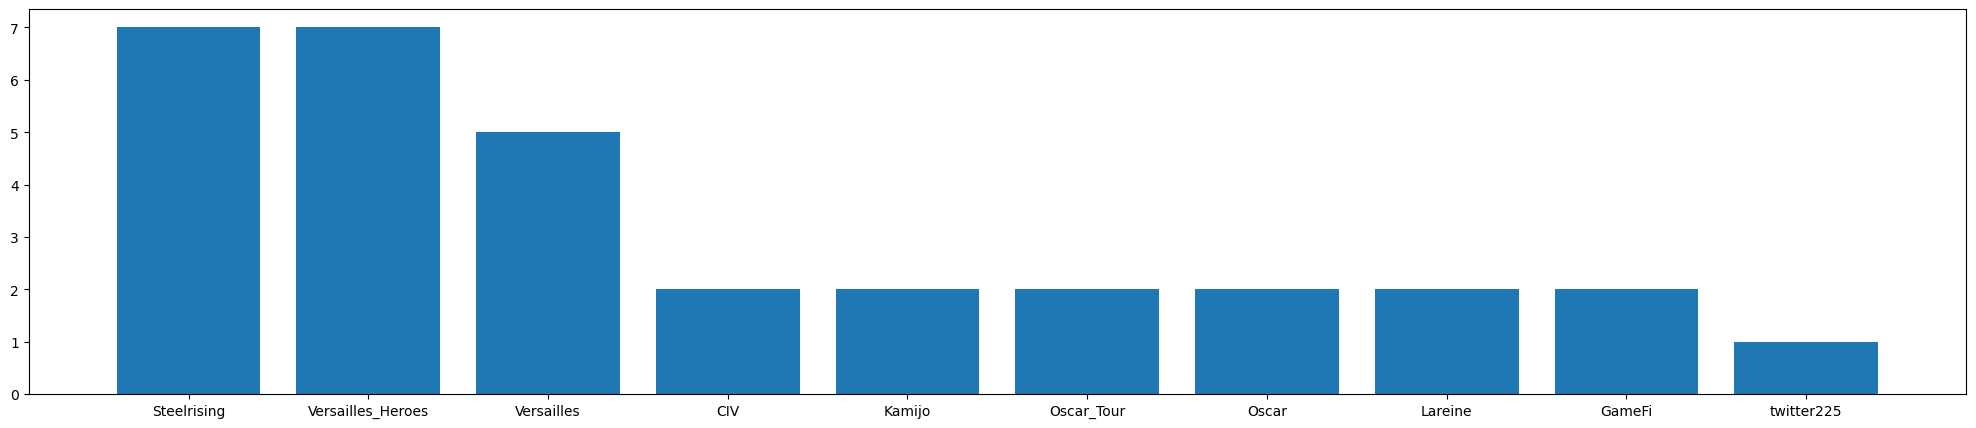

In [80]:
from matplotlib import pyplot as plt


def graph(categorie: str, source:pd.DataFrame, top:int = 0):
    """"
    Fonction qui crée un graphe de la répartition des tweet dans un domaine
    (Topics, mentions, hashtags ou author). 
    La variable top permet de réduire les données en donnant les meilleurs uniquement
    (si on indique 4: top 4).
    """
    #On extrait le dictionnaire qui contient la répartition des tweet.
    extract= list(extraire_dict(categorie, source).items())
    #On la trie en fonction des valeurs qu'elle contient (et non par ordre alphabétique)
    #Pour cela on utilise l'argument key, qui cible le deuxième élement du tuple clé, valeur
    extract.sort(key= lambda y: y[1], reverse=True)
    # Si l'utilisateur a spécifié un top, on restreint les données à celui-ci.
    if top != 0:
        extract = extract[:top]
    # On crée ensuite deux liste contenant les valeurs en abcisses (clé) et en ordonnées (quantité).
    x = []
    h = []
    for theme, valeur in extract:
        x.append(theme)
        h.append(valeur)
    plt.figure(figsize=(25,5))
    plt.bar(x,h)


graph("hashtags", pdTweetFiltre, 10)
